In [177]:
# 메모리내 변수 제거

all = [var for var in globals() if var[0] != "_"]   # globals() 목록의 첫글자가 _ 로 시작하지 않는 자료의 리스트만 가져와서
for var in all:
    del globals()[var]

In [178]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import wordcloud
import nltk
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.metrics import accuracy_score

In [179]:
train1 = pd.read_csv('c:/data/project/train.csv')
test = pd.read_csv('c:/data/project/test.csv')

In [180]:
train = train1.copy()
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


In [181]:
train.drop(columns=['ID', 'first_party', 'second_party'], inplace=True)
train.head()

,facts,first_party_winner
0,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,Ramon Nelson was riding his bike when he suffe...,0
2,An Alabama state court convicted Billy Joe Mag...,1
3,Victor Linkletter was convicted in state court...,0
4,"On April 24, 1953 in Selma, Alabama, an intrud...",1


In [182]:
# fig, axe = plt.subplots(ncols=1)
# fig.set_size_inches(6, 3)
# sns.countplot(train['first_party_winner'])

In [183]:
#train['first_party_winner'].value_counts()

In [184]:
train_target = pd.DataFrame(train, columns=['first_party_winner'])
train_target

,first_party_winner
0,1
1,0
2,1
3,0
4,1
...,...
2473,1
2474,1
2475,0
2476,0


In [185]:
train_nlp = train['facts']
train_nlp = pd.DataFrame(train_nlp, columns=['facts'])
train_nlp['facts'] = train_nlp['facts'].str.replace(r'<[^<>]*>', '', regex=True)
train_nlp

,facts
0,"On June 27, 1962, Phil St. Amant, a candidate ..."
1,Ramon Nelson was riding his bike when he suffe...
2,An Alabama state court convicted Billy Joe Mag...
3,Victor Linkletter was convicted in state court...
4,"On April 24, 1953 in Selma, Alabama, an intrud..."
...,...
2473,Congress amended the Clean Air Act through the...
2474,"Alliance Bond Fund, Inc., an investment fund, ..."
2475,"In 1992, the District Court sentenced Manuel D..."
2476,"On March 8, 1996, Enrico St. Cyr, a lawful per..."


In [186]:
#!pip install nltk

In [187]:
#nltk.download()

In [188]:
# from nltk.tokenize import WhitespaceTokenizer

# corpus = train_nlp['facts']
# Tokenizer=WhitespaceTokenizer()
# lst_tokens = Tokenizer.tokenize(str(corpus))
# lst_tokens
# # 공백 단위로 문자 쪼개기

#### 토큰화

In [189]:
import nltk

corpus = train_nlp["facts"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
# 어절 별로 키워드 반환
lst_tokens

['On',
 'June',
 '27',
 ',',
 '1962',
 ',',
 'Phil',
 'St.',
 'Amant',
 ',',
 'a',
 'candidate',
 'for',
 'public',
 'office',
 ',',
 'made',
 'a',
 'television',
 'speech',
 'in',
 'Baton',
 'Rouge',
 ',',
 'Louisiana',
 '.',
 'During',
 'this',
 'speech',
 ',',
 'St.',
 'Amant',
 'accused',
 'his',
 'political',
 'opponent',
 'of',
 'being',
 'a',
 'Communist',
 'and',
 'of',
 'being',
 'involved',
 'in',
 'criminal',
 'activities',
 'with',
 'the',
 'head',
 'of',
 'the',
 'local',
 'Teamsters',
 'Union',
 '.',
 'Finally',
 ',',
 'St.',
 'Amant',
 'implicated',
 'Herman',
 'Thompson',
 ',',
 'an',
 'East',
 'Baton',
 'Rouge',
 'deputy',
 'sheriff',
 ',',
 'in',
 'a',
 'scheme',
 'to',
 'move',
 'money',
 'between',
 'the',
 'Teamsters',
 'Union',
 'and',
 'St.',
 'Amant',
 '’',
 's',
 'political',
 'opponent',
 '.',
 'Thompson',
 'successfully',
 'sued',
 'St.',
 'Amant',
 'for',
 'defamation',
 '.',
 'Louisiana',
 '’',
 's',
 'First',
 'Circuit',
 'Court',
 'of',
 'Appeals',
 'reve

### 불용어 사전 정의 (사용자 지정 & 기본 제공[english])

In [190]:
##### 불용어 처리 및 어간과 표제어 추출 함수 #####

import re

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None): 
## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                        
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [191]:
##### 단어와 빈도수 측정 및 시각화 함수 #####

def word_freq(data, columns, titleName=None, graph=False):
    corpus = data[columns]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

    dic_word_freq = nltk.FreqDist(lst_tokens)
    words_freq = pd.DataFrame(dic_word_freq.most_common(), columns=["Word","Freq"])

    if graph==True:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        fig.suptitle('Most frequent words'+titleName, fontsize=15)
        figure(figsize=(30, 24))
        
        words_freq.set_index("Word").iloc[:50,:].sort_values(by="Freq").plot(
                  kind="barh", title="words", ax=ax, 
                  legend=False).grid(axis='x')
               
        ax.set(ylabel=None)
        plt.show()
    
    return [words_freq, dic_word_freq]

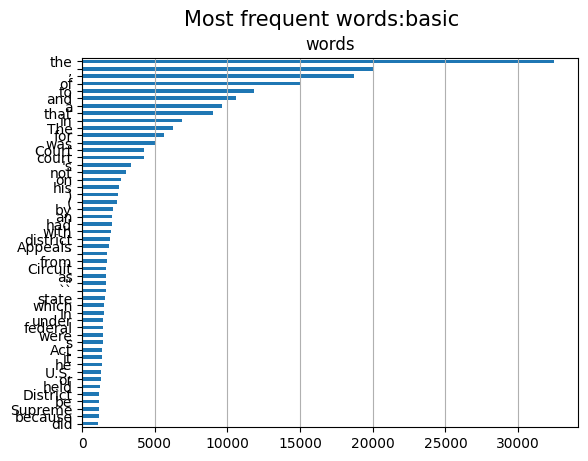

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,the,32500
1,",",20104
2,.,18697
3,of,15057
4,to,11798
...,...,...
21425,patentee,1
21426,localize,1
21427,spurious,1
21428,bar-coded,1


In [192]:
word_freq(train_nlp, 'facts', ':basic', True)[0]

##### 기본 불용어 처리

In [193]:
lst_stopwords = nltk.corpus.stopwords.words("english")
# NLTK가 정의한 영어 불용어 리스트를 리턴
#lst_stopwords

In [194]:
train_nlp["facts_lst_stopwords"] = train_nlp["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
train_nlp

,facts,facts_lst_stopwords
0,"On June 27, 1962, Phil St. Amant, a candidate ...",june 27 1962 phil st amant candidate public of...
1,Ramon Nelson was riding his bike when he suffe...,ramon nelson riding bike suffered lethal blow ...
2,An Alabama state court convicted Billy Joe Mag...,alabama state court convicted billy joe magwoo...
3,Victor Linkletter was convicted in state court...,victor linkletter convicted state court eviden...
4,"On April 24, 1953 in Selma, Alabama, an intrud...",april 24 1953 selma alabama intruder broke apa...
...,...,...
2473,Congress amended the Clean Air Act through the...,congress amended clean air act energy policy a...
2474,"Alliance Bond Fund, Inc., an investment fund, ...",alliance bond fund inc investment fund purchas...
2475,"In 1992, the District Court sentenced Manuel D...",1992 district court sentenced manuel peguero 2...
2476,"On March 8, 1996, Enrico St. Cyr, a lawful per...",march 8 1996 enrico st cyr lawful permanent re...


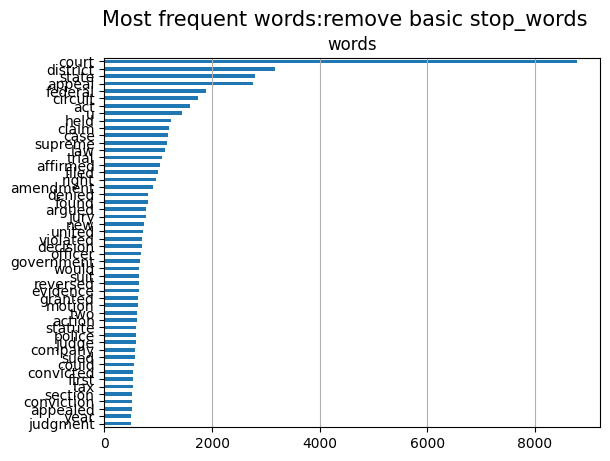

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,court,8776
1,district,3168
2,state,2793
3,appeal,2757
4,federal,1886
...,...,...
18013,patentee,1
18014,localize,1
18015,spurious,1
18016,barcoded,1


In [195]:
word_freq(train_nlp, 'facts_lst_stopwords', ':remove basic stop_words',True)[0]

##### 사용자 정의 불용어 사전 적용

In [196]:
# dic_words_freq = nltk.FreqDist(lst_tokens)
# dtf_uni = pd.DataFrame(dic_words_freq.most_common(), columns=["Word","Freq"])

# dtf_uni

dic_words_freq = word_freq(train_nlp, 'facts_lst_stopwords', False)[1]

stop_words=[]
for word, freq in dic_words_freq.most_common():
    if freq == 1:
        #print(word)
        stop_words.append(word)
# len(stop_words)
stop_words

['amants',
 'utter',
 'uninhibited',
 'robust',
 'happens',
 'unreliability',
 'owens',
 'interrogator',
 'tipping',
 'flowing',
 'trucked',
 'disrupting',
 'cargohandling',
 'barnetts',
 'senioritybased',
 'nondisabled',
 '1796',
 'paty',
 'mcdaniels',
 'meetingcompetition',
 '2b',
 'preapproval',
 '382',
 'householder',
 'thole',
 '404',
 '405',
 'overfunded',
 'undertake',
 'compiled',
 'guillens',
 'guillen',
 'educating',
 '1001',
 'exercisable',
 'martinezsalazars',
 'seating',
 'curatively',
 'complement',
 'headon',
 'alexa',
 'thanh',
 'mazda',
 'cassius',
 'tentatively',
 'conscientiously',
 'citigroups',
 'chemistry',
 'bassam',
 'yacoub',
 'karim',
 'antifish',
 'trapping',
 'trapped',
 'kake',
 'moor',
 'antitrapping',
 'dude',
 'intermingled',
 'regrant',
 'multimillion',
 'predated',
 'hiram',
 'extinction',
 'monitored',
 'selectiveprosecution',
 'stoltnielsen',
 'reevaluated',
 'terrorize',
 'empaneled',
 'bv',
 'herkimer',
 'locallyproduced',
 'publiclyowned',
 'sligh

In [197]:
train_nlp["facts_clear"] = train_nlp["facts_lst_stopwords"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=stop_words))
train_nlp

,facts,facts_lst_stopwords,facts_clear
0,"On June 27, 1962, Phil St. Amant, a candidate ...",june 27 1962 phil st amant candidate public of...,june 27 1962 phil st amant candidate public of...
1,Ramon Nelson was riding his bike when he suffe...,ramon nelson riding bike suffered lethal blow ...,ramon nelson riding bike suffered lethal blow ...
2,An Alabama state court convicted Billy Joe Mag...,alabama state court convicted billy joe magwoo...,alabama state court convicted billy joe magwoo...
3,Victor Linkletter was convicted in state court...,victor linkletter convicted state court eviden...,victor linkletter convicted state court eviden...
4,"On April 24, 1953 in Selma, Alabama, an intrud...",april 24 1953 selma alabama intruder broke apa...,april 24 1953 selma alabama intruder broke apa...
...,...,...,...
2473,Congress amended the Clean Air Act through the...,congress amended clean air act energy policy a...,congress amended clean air act energy policy a...
2474,"Alliance Bond Fund, Inc., an investment fund, ...",alliance bond fund inc investment fund purchas...,alliance bond fund inc investment fund purchas...
2475,"In 1992, the District Court sentenced Manuel D...",1992 district court sentenced manuel peguero 2...,1992 district court sentenced manuel peguero 2...
2476,"On March 8, 1996, Enrico St. Cyr, a lawful per...",march 8 1996 enrico st cyr lawful permanent re...,march 8 1996 st cyr lawful permanent resident ...


In [198]:
train_nlp['facts_lst_stopwords']==train_nlp['facts_clear']

0       False
1       False
2        True
3        True
4       False
        ...  
2473    False
2474    False
2475    False
2476    False
2477    False
Length: 2478, dtype: bool

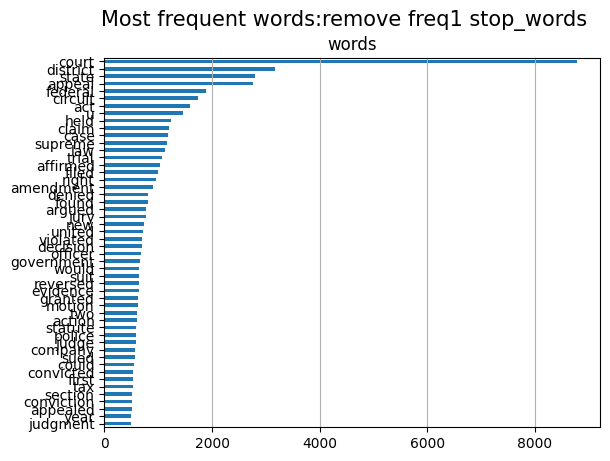

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,court,8776
1,district,3168
2,state,2793
3,appeal,2757
4,federal,1886
...,...,...
11264,drycleaning,2
11265,keyboard,2
11266,optical,2
11267,markmans,2


In [199]:
word_freq(train_nlp, 'facts_clear', ':remove freq1 stop_words',True)[0]

In [200]:
# user_stopwords = ["law", "court", "case", "plaintiff", "defendant", "judge", "trial", "jurisdiction", "evidence", "witness", "proceeding", "litigation", "party", "motion", "appeal", "action", "suit", "claim", "issue", "fact", "hearing", "counsel", "judgment", "order", "allegation", "argument", "brief", "charge", "complaint", "contract", "crime", "decision", "defense", "document", "file", "find", "hold", "injunction", "instruction", "lawyer", "legal", "liability", "matter", "notice", "opinion", "party", "plea", "point", "policy", "practice", "present", "prosecution", "record", "rule", "sentence", "statute", "testimony", "verdict", 'james', 'bike', 'named',"section", "act", "article", "chapter", "provision", "paragraph", "amendment", "code", "regulation", "statutory", "subsection", "constitution", "legislation", "ordinance", "regulatory", "rulemaking", "title", "enactment", "resolution", "treaty", "administrative", "bylaw",  "legislative", "prescription", "ratification", "repeal", "statutorily", "adjudicate", "adjudication", "arbitrate", "arbitration", "conciliation", "decree", "litigate", "mediation", "remand", "tribunal", "appellate", "affirm", "overrule", "reversal", "vacate", "writ", "certiorari", "mandamus", "subpoena", "arraignment", "indictment", "misdemeanor", "probation", "restitution", "summons", "verdict", "acquittal", "bail", "contempt", "conviction", "felony", "parole", "plea", "prosecutor", "sentence", "attorney", "barrister", "counsel", "juror", "litigator", "magistrate", "prosecutor", "solicitor", "stipulation", "testator", "trustee", "executor", "heir", "lease", "lessor", "lessee", "mortgagee", "mortgagor", "assignee", "assignor", "debtor", "creditor", "insurer", "insured", "beneficiary", "fiduciary", "principal", "agent"]
# words = [
#     'June', '27', '1962', 'Phil', 'St.', 'Amant', 'Baton', 'Rouge', 'Louisiana', 'During', 'this', 'television',
#     'speech', 'in', 'accused', 'his', 'political', 'opponent', 'being', 'and', 'of', 'involved', 'in', 'criminal',
#     'activities', 'with', 'the', 'head', 'of', 'local', 'Finally', 'implicated', 'Herman', 'Thompson', 'an', 'East',
#     'Baton', 'Rouge', 'deputy', 'sheriff', 'in', 'a', 'scheme', 'to', 'move', 'money', 'between', 'Teamsters', 'Union',
#     's', 'political', 'Thompson', 'successfully', 'sued', 'for', 'defamation', 'First', 'Circuit', 'Court', 'Appeals',
#     'reversed', 'holding', 'did', 'not', 'show', 'acted', 'with', 'malice', 'Thompson', 'then', 'appealed', 'Supreme',
#     'Court', 'Louisiana', 'court', 'that', 'although', 'public', 'figures', 'forfeit', 'some', 'their', 'Amendment',
#     'protection', 'from', 'defamation', 'accused', 'crime', 'utter', 'disregard', 'whether', 'remarks', 'were', 'true',
#     'uninhibited', 'robust', 'debate', 'rather', 'than', 'an', 'open', 'season', 'to', 'shoot', 'down', 'good', 'name',
#     'of', 'anyone', 'who', 'happens', 'be', 'servant', 'Ramon', 'Nelson', 'riding', 'his', 'bike', 'suffered', 'lethal',
#     'blow', 'back', 'with', 'baseball', 'bat', 'After', 'two', 'eyewitnesses', 'identified', 'Lawrence', 'Owens',
#     'array', 'photos', 'lineup', 'tried', 'convicted', 's', 'death', 'Because', 'carrying', 'cocaine', 'crack',
#     'potentially', 'for', 'distribution', 'judge', 'bench', 'trial', 'ruled', 'probably', 'also', 'drug', 'dealer',
#     'trying', 'knock', 'off', 'found', 'guilty', 'first-degree', 'murder', 'sentenced', 'years', 'prison', 'filed',
#     'petition', 'writ', 'habeas', 'corpus', 'grounds', 'constitutional', 'due', 'process', 'violated', 'during',
#     'argued', 'eyewitness', 'identification', 'should', 'have', 'been', 'inadmissible', 'based', 'unreliability',
#     'impermissibly', 'inferred', 'm']

# stopwords=set(user_stopwords+words)
# stopwords

#### 승소, 패소 시의 단어 빈도수 확인

###### 위의 전처리 과정에서 얻은 facts_clear와 first_party_winner만 남긴 데이터 프레임을 train_nlp2로 지정함

In [201]:
train_nlp2 = pd.concat([train_nlp,train_target['first_party_winner']],axis=1, join='inner')

#print(train_nlp2["first_party_winner"].value_counts())
train_nlp2.drop(columns=['facts', 'facts_lst_stopwords'], inplace=True)
train_nlp2
#train_nlp2['first_party_winner'].value_counts()

,facts_clear,first_party_winner
0,june 27 1962 phil st amant candidate public of...,1
1,ramon nelson riding bike suffered lethal blow ...,0
2,alabama state court convicted billy joe magwoo...,1
3,victor linkletter convicted state court eviden...,0
4,april 24 1953 selma alabama intruder broke apa...,1
...,...,...
2473,congress amended clean air act energy policy a...,1
2474,alliance bond fund inc investment fund purchas...,1
2475,1992 district court sentenced manuel peguero 2...,0
2476,march 8 1996 st cyr lawful permanent resident ...,0


##### 승소 시 단어 빈도 수 -> 빈도수가 1인 단어가 꽤 존재함 -> 이를 제거할지 고민해봐야함

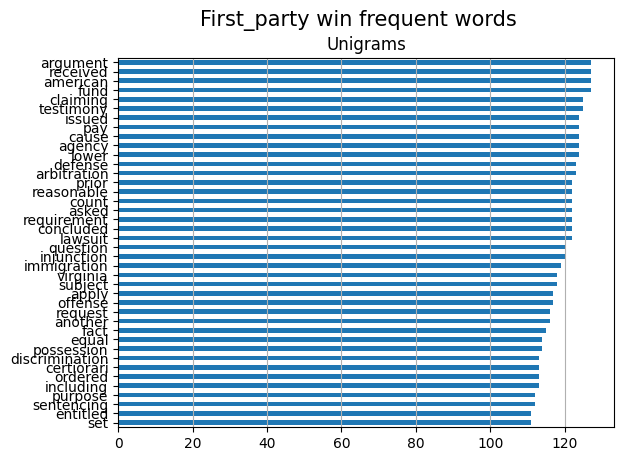

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,court,5943
1,district,2071
2,appeal,1856
3,state,1827
4,federal,1250
...,...,...
9942,succeeded,1
9943,tucson,1
9944,formulate,1
9945,elective,1


In [202]:
y=1
corpus1 = train_nlp2[train_nlp2["first_party_winner"]== y]["facts_clear"]
first_tokens = nltk.tokenize.word_tokenize(corpus1.str.cat(sep=" "))

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle("First_party win frequent words", fontsize=15)
figure(figsize=(30, 24))

first_words_freq = nltk.FreqDist(first_tokens)
dtf_uni1 = pd.DataFrame(first_words_freq.most_common(), columns=["Word","Freq"])
# dtf_uni[40:60]
dtf_uni1.set_index("Word").iloc[200:240,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax, 
                  legend=False).grid(axis='x')
ax.set(ylabel=None)
plt.show()    

dtf_uni1
# first_win_words = dtf_uni1['Word'][:50]

##### 패소 시 단어 빈도 수

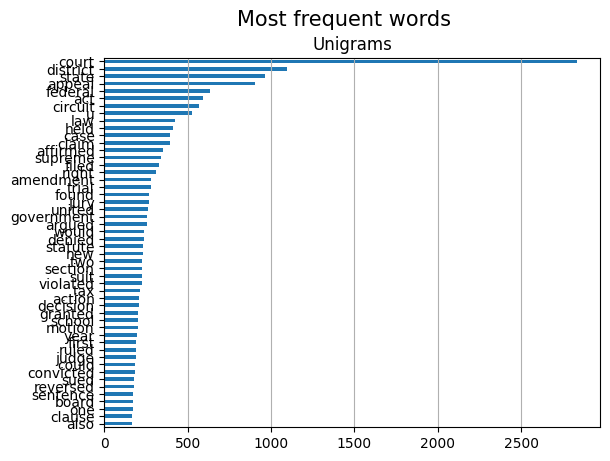

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,court,2833
1,district,1097
2,state,966
3,appeal,901
4,federal,636
...,...,...
7794,communicate,1
7795,ace,1
7796,lopezs,1
7797,274,1


In [203]:
y=0
corpus0 = train_nlp2[train_nlp2["first_party_winner"]== y]["facts_clear"]
lst_tokens = nltk.tokenize.word_tokenize(corpus0.str.cat(sep=" "))

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
figure(figsize=(30, 24))

dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni0 = pd.DataFrame(dic_words_freq.most_common(), columns=["Word","Freq"])
# dtf_uni[40:60]
dtf_uni0.set_index("Word").iloc[:50,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax, 
                  legend=False).grid(axis='x')
ax.set(ylabel=None)
plt.show()    

dtf_uni0

#### Wordcloud

In [204]:
# !pip install wordcloud

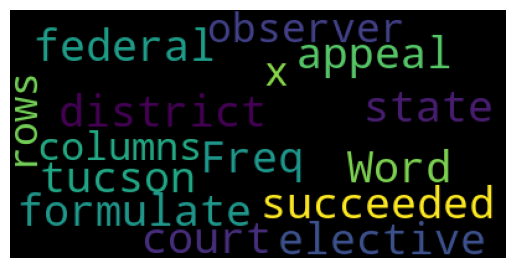

In [205]:
wc1 = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc1 = wc1.generate(str(dtf_uni1))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc1, cmap=None)
plt.show()

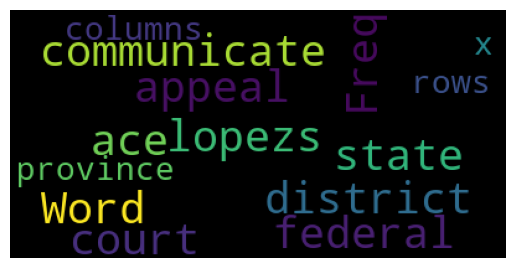

In [206]:
wc0 = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc0 = wc0.generate(str(dtf_uni0))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc0, cmap=None)
plt.show()

## Define Model & Train

In [207]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer()

In [209]:
train_nlp2
train_nlp2 = pd.concat([train_nlp2,train1['first_party']],axis=1, join='inner')
train_nlp2 = pd.concat([train_nlp2,train1['second_party']],axis=1, join='inner')
train_nlp2

,facts_clear,first_party_winner,first_party,second_party
0,june 27 1962 phil st amant candidate public of...,1,Phil A. St. Amant,Herman A. Thompson
1,ramon nelson riding bike suffered lethal blow ...,0,Stephen Duncan,Lawrence Owens
2,alabama state court convicted billy joe magwoo...,1,Billy Joe Magwood,"Tony Patterson, Warden, et al."
3,victor linkletter convicted state court eviden...,0,Linkletter,Walker
4,april 24 1953 selma alabama intruder broke apa...,1,William Earl Fikes,Alabama
...,...,...,...,...
2473,congress amended clean air act energy policy a...,1,"HollyFrontier Cheyenne Refining, LLC, et al.","Renewable Fuels Association, et al."
2474,alliance bond fund inc investment fund purchas...,1,"Grupo Mexicano de Desarrollo, S. A.","Alliance Bond Fund, Inc."
2475,1992 district court sentenced manuel peguero 2...,0,Peguero,United States
2476,march 8 1996 st cyr lawful permanent resident ...,0,Immigration and Naturalization Service,St. Cyr


In [210]:
vectorizer = TfidfVectorizer()

def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts_clear'])
    else:
        X_facts = vectorizer.transform(df['facts_clear'])
    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])
    
    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

X_train = get_vector(vectorizer, train_nlp, True)
Y_train = train_nlp2["first_party_winner"]
X_test = get_vector(vectorizer, test, False)

In [211]:
# xfeatures = train_nlp2['facts_clear']
# ylabel = train_nlp2['first_party_winner']
# xfeatures
# ylabel

In [212]:
xfeatures = list(train_nlp2['facts_clear'])
ylabel = list(train_nlp2['first_party_winner'])

X = vectorizer.fit_transform(xfeatures)
# print(X)
# X.shape
# 2478개의 판결문을 표현하기 위해 총 11238개의 단어가 사용됨 -> 불용어 전처리를 한 상태에서

In [213]:
# from sklearn.metrics.pairwise import cosine_similarity
# cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [214]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, ylabel, test_size=0.25, random_state=11)

In [215]:
# X_train.count(), X_test.count(), y_train.count(), y_test.count()

In [216]:
# X_train = vectorizer.fit_transform(X_train)
# X_test = vectorizer.transform(X_test)

#### LogisticRegression

In [217]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [218]:
print("Accuracy : %f" % lr.score(X_test, y_test)) # 검증 데이터로 성능 측정
accuracy_score(y_test, lr.predict(X_test))

Accuracy : 0.666129


0.6661290322580645

In [219]:
test = pd.DataFrame(lr.predict(X_test))
test.value_counts()

1    613
0      7
Name: count, dtype: int64

In [220]:
# lr.predict(X_train)
# lr.predict(X_test)

In [221]:
lr.score(X_test, y_test)

0.6661290322580645

#### XGBoost

In [222]:
#!pip install xgboost

In [223]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(
                      booster = 'gbtree',
                      scale_pos_weight=5,
                      learning_rate=0.01,  
                      colsample_bytree = 0.7,
                      subsample = 0.5,
                      max_delta_step = 3,
                      reg_lambda = 2,
                      objective='binary:logistic',
                      n_estimators=818, 
                      max_depth=8,
                     )


xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=3,
              max_depth=8, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=818, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [224]:
y_pred = xgb.predict_proba(X_test)
y_pred

array([[0.05189914, 0.94810086],
       [0.3611952 , 0.6388048 ],
       [0.11002833, 0.8899717 ],
       ...,
       [0.09042197, 0.909578  ],
       [0.1669277 , 0.8330723 ],
       [0.03126216, 0.96873784]], dtype=float32)

In [225]:
xgb.score(X_test, y_test)

0.6693548387096774

In [226]:
# tfidf_matrix = vectorizer.fit_transform(train['facts'])

# from sklearn.metrics.pairwise import cosine_similarity
# # 첫 번째와 두 번째 문장 비교
# cos_similar = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
# print("코사인 유사도 측정")
# print(cos_similar)

In [227]:
tfidfv = TfidfVectorizer().fit(train['facts'])
print(tfidfv.vocabulary_)
print("="*100)
print(tfidfv.transform(train['facts']).toarray())
print("="*100)
print(tfidfv.fit_transform(train['facts']).toarray())

{'on': 11300, 'june': 8968, '27': 352, '1962': 233, 'phil': 11996, 'st': 14991, 'amant': 1383, 'candidate': 2920, 'for': 6763, 'public': 12745, 'office': 11251, 'made': 9834, 'television': 15696, 'speech': 14902, 'in': 8202, 'baton': 2158, 'rouge': 13907, 'louisiana': 9745, 'during': 5518, 'this': 15846, 'accused': 922, 'his': 7811, 'political': 12180, 'opponent': 11342, 'of': 11235, 'being': 2243, 'communist': 3652, 'and': 1456, 'involved': 8711, 'criminal': 4314, 'activities': 972, 'with': 17250, 'the': 15798, 'head': 7642, 'local': 9656, 'teamsters': 15662, 'union': 16453, 'finally': 6612, 'implicated': 8153, 'herman': 7738, 'thompson': 15850, 'an': 1433, 'east': 5570, 'deputy': 4845, 'sheriff': 14489, 'scheme': 14152, 'to': 15937, 'move': 10652, 'money': 10553, 'between': 2321, 'successfully': 15317, 'sued': 15326, 'defamation': 4640, 'first': 6651, 'circuit': 3355, 'court': 4233, 'appeals': 1564, 'reversed': 13694, 'holding': 7848, 'that': 15797, 'did': 5001, 'not': 11076, 'show':

In [228]:
from sklearn.metrics.pairwise import linear_kernel
tfidf_matrix = tfidfv.fit_transform(train['facts'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.04744614, 0.03722288, ..., 0.05230033, 0.14694784,
        0.0408811 ],
       [0.04744614, 1.        , 0.11354639, ..., 0.12967811, 0.07652896,
        0.08114463],
       [0.03722288, 0.11354639, 1.        , ..., 0.13816648, 0.07992237,
        0.06304225],
       ...,
       [0.05230033, 0.12967811, 0.13816648, ..., 1.        , 0.09202424,
        0.09930054],
       [0.14694784, 0.07652896, 0.07992237, ..., 0.09202424, 1.        ,
        0.06133021],
       [0.0408811 , 0.08114463, 0.06304225, ..., 0.09930054, 0.06133021,
        1.        ]])

In [229]:
tfidfv.vocabulary_.keys()

dict_keys(['on', 'june', '27', '1962', 'phil', 'st', 'amant', 'candidate', 'for', 'public', 'office', 'made', 'television', 'speech', 'in', 'baton', 'rouge', 'louisiana', 'during', 'this', 'accused', 'his', 'political', 'opponent', 'of', 'being', 'communist', 'and', 'involved', 'criminal', 'activities', 'with', 'the', 'head', 'local', 'teamsters', 'union', 'finally', 'implicated', 'herman', 'thompson', 'an', 'east', 'deputy', 'sheriff', 'scheme', 'to', 'move', 'money', 'between', 'successfully', 'sued', 'defamation', 'first', 'circuit', 'court', 'appeals', 'reversed', 'holding', 'that', 'did', 'not', 'show', 'acted', 'malice', 'then', 'appealed', 'supreme', 'held', 'although', 'figures', 'forfeit', 'some', 'their', 'amendment', 'protection', 'from', 'crime', 'utter', 'disregard', 'whether', 'remarks', 'were', 'true', 'protects', 'uninhibited', 'robust', 'debate', 'rather', 'than', 'open', 'season', 'shoot', 'down', 'good', 'name', 'anyone', 'who', 'happens', 'be', 'servant', 'ramon', '

In [230]:
#word_list = [i for i in sorted(tfidfv.vocabulary_.keys())]
word_list=tfidfv.vocabulary_.keys()
# vec_X_train을 DataFrame 화
pd.DataFrame(tfidf_matrix.toarray(), columns=word_list)
#pd.DataFrame(cosine_sim, columns=word_list)

,on,june,27,1962,phil,st,amant,candidate,for,public,...,processor,readable,optical,detectors,patentee,localize,spurious,westview,coded,province
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2474,0.0,0.046666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2475,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2476,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [231]:
model = LogisticRegression()
model.fit(X_train, Y_train)

NameError: name 'Y_train' is not defined

## Inference & Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
pred = model.predict(X_test)

In [ ]:
submit['first_party_winner'] = pred
submit.to_csv('./baseline_submit.csv', index=False)
print('Done')